In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='whitegrid')
from vega_datasets import data

import pymc3 as pm
import theano.tensor as tt
import arviz as az

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

In [2]:
%load_ext watermark
%watermark -v -iv

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.19.0

theano    : 1.0.5
seaborn   : 0.11.0
numpy     : 1.19.2
sklearn   : 0.23.2
matplotlib: 3.3.2
pandas    : 1.1.3
pymc3     : 3.9.3
arviz     : 0.10.0



### Data

In [3]:
iris = sns.load_dataset('iris')
iris

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


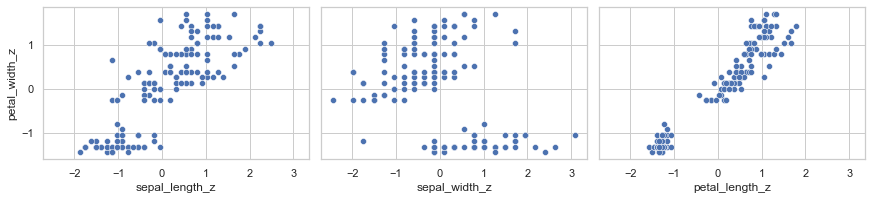

In [78]:
# standardize variables (much easier to think about priors etc on standard scale)
iris[['sepal_length_z','sepal_width_z','petal_length_z','petal_width_z']] = StandardScaler().fit_transform(iris[['sepal_length','sepal_width','petal_length','petal_width']])

fig, axes = plt.subplots(ncols=3, constrained_layout=True, figsize=(12,4), sharex=True, sharey=True)
sns.scatterplot(data=iris, x='sepal_length_z', y='petal_width_z', ax=axes[0])
sns.scatterplot(data=iris, x='sepal_width_z', y='petal_width_z', ax=axes[1])
sns.scatterplot(data=iris, x='petal_length_z', y='petal_width_z', ax=axes[2])

for ax in axes:
    ax.set(aspect='equal')

### PyMC3 Model

In [169]:
# lifesaver for making predictions on new data
def model_factory(x_in, y_in):
    with pm.Model() as model:
        # data
        x = pm.Data('x', x_in)
        y = pm.Data('y', y_in)

        # priors on parameters
        α = pm.Normal('α', 0, 1)
        β = pm.Normal('β', 0, 1, shape=x_in.shape[1])
        # β1 = pm.Normal('β1', 0, 1)
        # β2 = pm.Normal('β2', 0, 1)
        # β3 = pm.Normal('β3', 0, 1)
        σ = pm.HalfNormal('σ', 1)

        # model
        μ = pm.Deterministic('μ', x @ β + α) # matrix multiplication here is neccessary
        # μ = pm.Deterministic('μ', x[:,0] * β1 + x[:,1] * β2 + x[:,2] * β3 + α) 
        y_hat = pm.Normal('y_hat', mu=μ, sigma=σ, observed=y)
    return model

In [170]:
model = model_factory(iris[['sepal_length_z','sepal_width_z','petal_length_z']], iris['petal_width_z'])
model

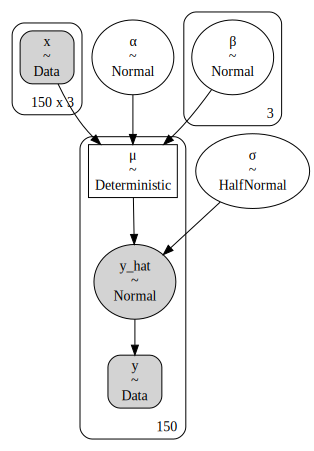

In [171]:
pm.model_to_graphviz(model)

In [172]:
with model:
    # Prior sampling, trace definition and posterior sampling
    prior = pm.sample_prior_predictive()
    posterior = pm.sample()
    posterior_pred = pm.sample_posterior_predictive(posterior)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β, α]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.
The acceptance probability does not match the target. It is 0.8851402193662903, but should be close to 0.8. Try to increase the number of tuning steps.


In [ ]:
inf_obj = az.from_pymc3(prior=prior, trace=posterior, posterior_predictive=posterior_pred,
                        model=model)
az.to_netcdf(inf_obj, 'model_12.netcdf')
inf_obj

In [ ]:
inf_obj = az.from_netcdf('model_12.netcdf')
inf_obj

In [173]:
az.summary(inf_obj, var_names=['~μ'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
α,-0.000,0.021,-0.039,0.039,0.000,0.000,3673.0,1907.0,3673.0,2836.0,1.0
β[0],-0.220,0.052,-0.322,-0.123,0.001,0.001,1623.0,1623.0,1618.0,2213.0,1.0
β[1],0.126,0.028,0.073,0.179,0.001,0.000,1915.0,1915.0,1916.0,2431.0,1.0
β[2],1.208,0.057,1.098,1.316,0.001,0.001,1488.0,1488.0,1474.0,2022.0,1.0
σ,0.255,0.016,0.226,0.283,0.000,0.000,3011.0,3002.0,3046.0,2546.0,1.0


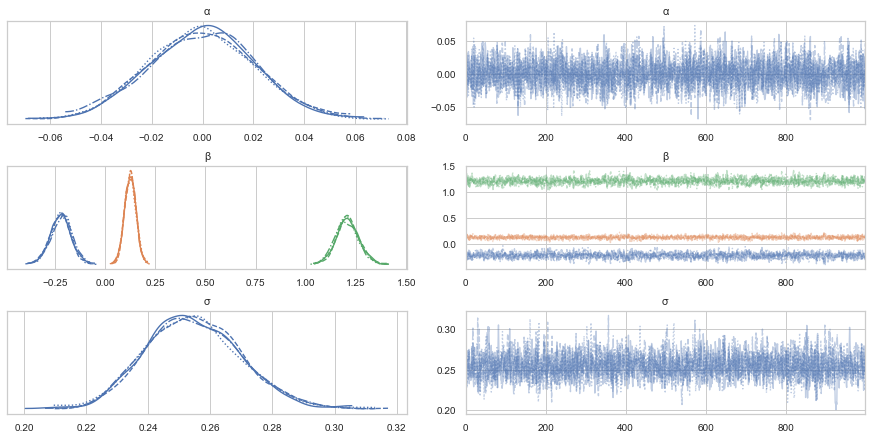

In [174]:
pm.traceplot(inf_obj, var_names=['~μ']);

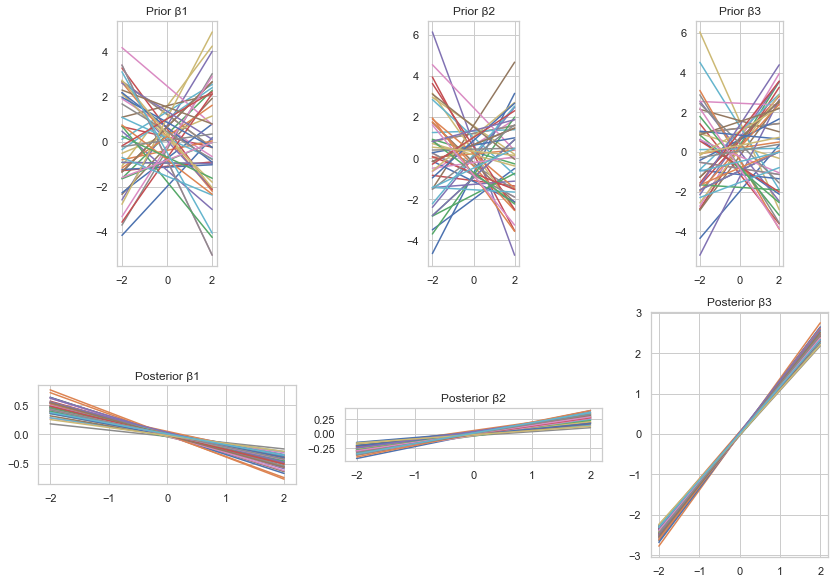

In [120]:
nshow = 50

samples = 500 # default n_samples for prior in pymc3
idx = np.random.randint(0, samples, nshow)

fig, axes = plt.subplots(ncols=3, nrows=2, constrained_layout=True, figsize=(12,8))

for α, β1,β2,β3 in zip(inf_obj.prior.get('α').values.flatten()[idx], 
                       inf_obj.prior.get('β').values[0, idx, 0],
                       inf_obj.prior.get('β').values[0, idx, 1],
                       inf_obj.prior.get('β').values[0, idx, 2]):
    xs = np.linspace(-2, 2)
    axes[0,0].plot(xs, β1 * xs + α)
    axes[0,1].plot(xs, β2 * xs + α)
    axes[0,2].plot(xs, β3 * xs + α)
axes[0,0].set(title='Prior β1');
axes[0,1].set(title='Prior β2');
axes[0,2].set(title='Prior β3');

samples = 1000 # default n_samples for trace in pymc3
idx = np.random.randint(0, samples, nshow)

for α, β1,β2,β3 in zip(inf_obj.posterior.get('α').values.flatten()[idx], 
                       inf_obj.posterior.get('β').values[0, idx, 0],
                       inf_obj.posterior.get('β').values[0, idx, 1],
                       inf_obj.posterior.get('β').values[0, idx, 2]):
    xs = np.linspace(-2, 2)
    axes[1,0].plot(xs, β1 * xs + α)
    axes[1,1].plot(xs, β2 * xs + α)
    axes[1,2].plot(xs, β3 * xs + α)
axes[1,0].set(title='Posterior β1');
axes[1,1].set(title='Posterior β2');
axes[1,2].set(title='Posterior β3');

for ax in axes.flatten():
    ax.set(aspect='equal')

### sklearn Model

In [175]:
clf = LinearRegression()
clf.fit(iris[['sepal_length_z','sepal_width_z','petal_length_z']], iris['petal_width_z'])

LinearRegression()

### Analysis and comparison

In [176]:
map_est = pm.find_MAP(model=model)

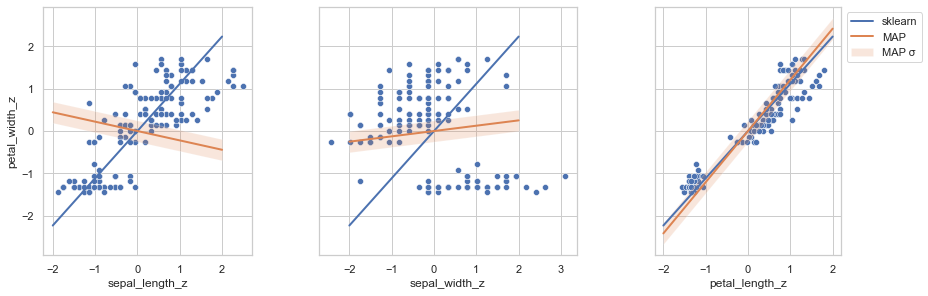

In [81]:
# THESE SPLIT CHARTS MAKE NO SENSE, NOT EVEN SURE IF THEY'RE WORTH "FIXING"

fig, axes = plt.subplots(ncols=3, constrained_layout=True, figsize=(13,4), sharey=True)

sns.scatterplot(data=iris, x='sepal_length_z', y='petal_width_z', ax=axes[0])
sns.scatterplot(data=iris, x='sepal_width_z', y='petal_width_z', ax=axes[1])
sns.scatterplot(data=iris, x='petal_length_z', y='petal_width_z', ax=axes[2])

xs = np.linspace(-2, 2)
x_mat = np.tile(xs, (3,1)).T
for ax in axes:
    ax.plot(xs, clf.predict(x_mat), linewidth=2, label='sklearn')

for i, ax in enumerate(axes):
    ax.plot(xs, map_est['β'][i] * xs + map_est['α'], linewidth=2, label='MAP')
    ax.fill_between(xs, 
                    map_est['β'][i] * xs + map_est['α'] + map_est['σ'], 
                    map_est['β'][i] * xs + map_est['α'] - map_est['σ'], 
                    alpha=0.2, label='MAP σ')

axes[2].legend(bbox_to_anchor=(1,1))

for ax in axes:
    ax.set(aspect='equal')

In [177]:
# dummy Y values are passed (these are not used but a vector of correct shape needs to be given here)
x_mat_test = iris[['sepal_length_z','sepal_width_z','petal_length_z']].values
with model_factory(x_mat_test, np.zeros(len(x_mat_test))) as model_test:
    # use training trace to generate posterior samples on test set
    new_preds = pm.sample_posterior_predictive(posterior)

C:\Users\ruote\Anaconda3\envs\pymc\lib\site-packages\arviz\stats\stats.py:484: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


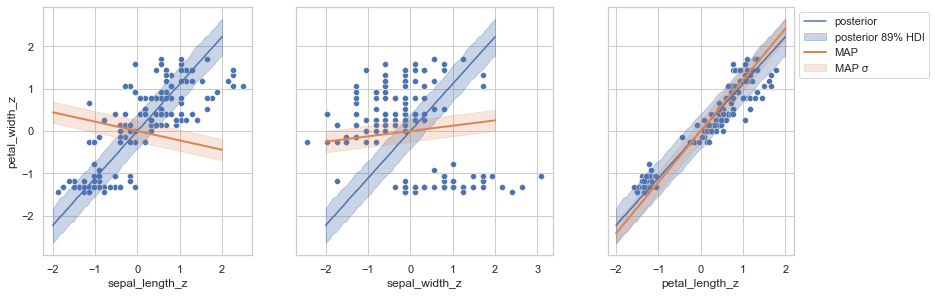

In [89]:
fig, axes = plt.subplots(ncols=3, constrained_layout=True, figsize=(13,4), sharey=True)

sns.scatterplot(data=iris, x='sepal_length_z', y='petal_width_z', ax=axes[0])
sns.scatterplot(data=iris, x='sepal_width_z', y='petal_width_z', ax=axes[1])
sns.scatterplot(data=iris, x='petal_length_z', y='petal_width_z', ax=axes[2])

xs = np.linspace(-2, 2)
x_mat = np.tile(xs, (3,1)).T

hdi = az.hdi(new_preds['y_hat'], hdi_prob=0.89)
for ax in axes:
    ax.fill_between(xs, hdi[:,0], hdi[:,1], alpha=0.3, color='C0', label='posterior 89% HDI')
    ax.plot(xs, new_preds['y_hat'].mean(axis=0), color='C0', label='posterior')

for i, ax in enumerate(axes):
    ax.plot(xs, map_est['β'][i] * xs + map_est['α'], linewidth=2, color='C1', label='MAP')
    ax.fill_between(xs, 
                    map_est['β'][i] * xs + map_est['α'] + map_est['σ'], 
                    map_est['β'][i] * xs + map_est['α'] - map_est['σ'], 
                    alpha=0.2, color='C1', label='MAP σ')

for ax in axes:
    ax.set(aspect='equal')

# reorder legend
axes[2].legend()
handles, labels = ax.get_legend_handles_labels()
ax.legend([handles[0], handles[2], handles[1], handles[3]], 
          [labels[0], labels[2], labels[1], labels[3]], 
          bbox_to_anchor=(1,1));

In [196]:
from sklearn.metrics import mean_absolute_error

In [203]:
print(mean_absolute_error(iris['petal_width_z'], clf.predict(iris[['sepal_length_z','sepal_width_z','petal_length_z']]) ))
print(mean_absolute_error(iris['petal_width_z'], iris[['sepal_length_z','sepal_width_z','petal_length_z']].values @ map_est['β'] + map_est['α'] ))
print(mean_absolute_error(iris['petal_width_z'], new_preds['y_hat'].mean(axis=0) ))

0.18838337321661566
0.1884708501703627
0.1885464958452362


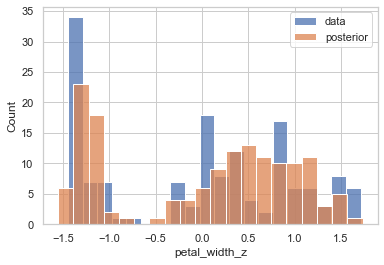

In [191]:
fig, ax = plt.subplots()
sns.histplot(data=iris, x='petal_width_z', bins=20, label='data', ax=ax)
sns.histplot(x=new_preds['y_hat'].mean(axis=0), bins=20, color='C1', label='posterior', ax=ax)
ax.legend();

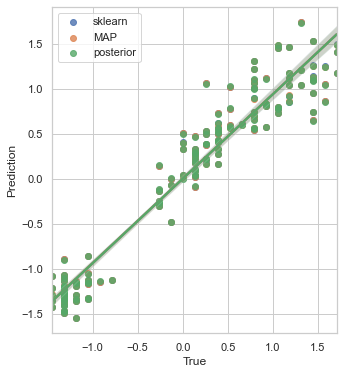

In [180]:
fig, ax = plt.subplots(figsize=(6,6))

sns.regplot(x=iris['petal_width_z'], 
            y=clf.predict(iris[['sepal_length_z','sepal_width_z','petal_length_z']]), 
            label='sklearn',
            ax=ax)

sns.regplot(x=iris['petal_width_z'], 
            y=iris[['sepal_length_z','sepal_width_z','petal_length_z']].values @ map_est['β'] + map_est['α'], 
            label='MAP',
            ax=ax)

sns.regplot(x=iris['petal_width_z'], 
            y=new_preds['y_hat'].mean(axis=0), 
            label='posterior',
            ax=ax)

ax.set(xlabel='True', ylabel='Prediction', aspect='equal')
ax.legend();